# Фоллоуап: разная базовая конверсия

В прошлой работе я упоминал, что очень важно не просто полагаться на показанные мной закономерности, а считать мощность/FPR для вашего конкретного случая. Сейчас я попробую продемонстрировать это наглядно и объяснить, почему так получается.

In [1]:
import numpy as np #для симуляций и ряда вспомогательных функций
import pandas as pd #создание датафреймов, имеет вспомогательную роль
import scipy.stats as st #"классические" статметоды и бутстрап
import statsmodels.api as sm #регрессия
import patsy #дизайн-матрицы
import seaborn as sns #отрисовка результатов
from tqdm.auto import tqdm #шкала прогресса

#эта функция создаёт генератор случайных чисел, который пригодится нам для симуляций
rng = np.random.default_rng()

#это уберёт предупреждения, которые могут выкидывать некоторые методы
import warnings
warnings.filterwarnings("ignore")

## 1. Симуляции (опять)

В этот раз я не буду делать функцию под каждый отдельный тест - вместо этого я создам одну функцию, которая проверяет на мощность/FPR все тесты сразу! Это и место экономит, и дополнительно упрощает сравнение: все тесты проверяются ровно на тех же данных, и разброс результатов между перезапусками не играет такой большой роли.

Я решил не указывать тут бутстрап (т.к. долго) и Пуассон-регрессию (т.к. избыточно). Сравним хи-квадрат, t-тест и логистическую регрессию.

In [5]:
def three_power_uneq(conv_control, conv_test, sample_size, test_prop, num_iter, rng, alpha=0.05):

    '''
    Функция считает мощность для трёх тестов методом Монте-Карло (независимые наблюдения, неравный размер групп).

    * conv_control - значение конверсии в контрольной группе
    * conv_test - значение конверсии в тестовой группе
    * sample_size - размер выборки (контрольная группа)
    * test_prop - какую пропорцию составляет размер тестовой группы от размера контрольной
    * num_iter - количество симуляций Монте-Карло
    * rng - генератор случайных чисел
    * alpha - уровень значимости (по умолчанию 0.05)
    
    '''
    #в списки мы будем складывать результаты тестов
    pvals_chi = [] #хи-квадрат
    pvals_t = [] #t-тест
    pvals_logit = [] #логистическая регрессия

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = rng.binomial(n=1, p=conv_control, size=sample_size) #данные контрольной группы
        test = rng.binomial(n=1, p=conv_test, size=round(sample_size*test_prop)) #данные тестовой группы

        #общая переменная с данными групп
        data = np.concatenate([control, test]) 
        #индикаторы принадлежности наблюдения к группе
        group = np.concatenate([np.repeat(0, repeats=sample_size), 
                                np.repeat(1, repeats=round(sample_size*test_prop))]) 

        #на основе полученных данных строим таблицу сопряженности
        #используем тест, извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals_chi.append(st.chi2_contingency(st.contingency.crosstab(group, data).count).pvalue < alpha)
        pvals_t.append(st.ttest_ind(control, test, equal_var=False).pvalue < alpha)
        pvals_logit.append(sm.Logit(data, sm.add_constant(group)).fit(disp=False).pvalues[1] < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    #делаем из этого всего датафрейм

    if conv_control != conv_test:
        col_name = "Power"
    else:
        col_name = "FPR"

    df_res = pd.DataFrame({"Sample":sample_size, "Proportion":test_prop, 
                           "Test":["Chi-square", "T-test", "Logistic reg."], 
                           col_name:[np.mean(pvals_chi), np.mean(pvals_t), np.mean(pvals_logit)]})
    return(df_res)

Для проверки запустим код с теми же настройками, что было раньше - 20% в контроле, 25% в тесте:

In [14]:
three_power_uneq(conv_control=0.2, conv_test=0.25, 
                 sample_size=1000, test_prop=1, 
                 rng=rng, num_iter=10000) #мощность, равные выборки

,Sample,Proportion,Test,Power
0,1000,1,Chi-square,0.7534
1,1000,1,T-test,0.7694
2,1000,1,Logistic reg.,0.7689


In [15]:
three_power_uneq(conv_control=0.2, conv_test=0.25, 
                 sample_size=1000, test_prop=0.05, 
                 rng=rng, num_iter=10000) #мощность, неравные выборки

,Sample,Proportion,Test,Power
0,1000,0.05,Chi-square,0.1211
1,1000,0.05,T-test,0.0903
2,1000,0.05,Logistic reg.,0.1525


In [16]:
three_power_uneq(conv_control=0.2, conv_test=0.2, 
                 sample_size=1000, test_prop=1, 
                 rng=rng, num_iter=10000) #FPR, равные выборки

,Sample,Proportion,Test,FPR
0,1000,1,Chi-square,0.0419
1,1000,1,T-test,0.0479
2,1000,1,Logistic reg.,0.0476


In [17]:
three_power_uneq(conv_control=0.2, conv_test=0.2, 
                 sample_size=1000, test_prop=0.05, 
                 rng=rng, num_iter=10000) #FPR, неравные выборки

,Sample,Proportion,Test,FPR
0,1000,0.05,Chi-square,0.0320
1,1000,0.05,T-test,0.0600
2,1000,0.05,Logistic reg.,0.0443


Пока наблюдаем все те же самые паттерны и числа, что и до этого. Более того, теперь видно, что на самом деле логистическая регрессия самую чуточку менее чувствительна, чем t-тест (на доли процента).

Теперь посчитаем для других конверсий - 5% в контроле и 10% в тесте:

In [6]:
three_power_uneq(conv_control=0.05, conv_test=0.1, sample_size=1000, test_prop=1, rng=rng, num_iter=10000)

,Sample,Proportion,Test,Power
0,1000,1,Chi-square,0.9888
1,1000,1,T-test,0.9905
2,1000,1,Logistic reg.,0.9905


In [7]:
three_power_uneq(conv_control=0.05, conv_test=0.1, sample_size=1000, test_prop=0.05, rng=rng, num_iter=10000)

,Sample,Proportion,Test,Power
0,1000,0.05,Chi-square,0.2876
1,1000,0.05,T-test,0.1157
2,1000,0.05,Logistic reg.,0.3490


In [8]:
three_power_uneq(conv_control=0.05, conv_test=0.05, sample_size=1000, test_prop=1, rng=rng, num_iter=10000)

,Sample,Proportion,Test,FPR
0,1000,1,Chi-square,0.0385
1,1000,1,T-test,0.0492
2,1000,1,Logistic reg.,0.0481


In [9]:
three_power_uneq(conv_control=0.05, conv_test=0.05, sample_size=1000, test_prop=0.05, rng=rng, num_iter=10000)

,Sample,Proportion,Test,FPR
0,1000,0.05,Chi-square,0.0235
1,1000,0.05,T-test,0.0862
2,1000,0.05,Logistic reg.,0.0371


Опаньки. Смотрите, что получилось:

1. Несмотря на то, что мы проверяем (казалось бы) тот же размер эффекта, мощность резко увеличилась
2. При диспропорции выборок различия между тестами стали более подчёркнутыми: t-тест ведёт себя хуже, а логистическая регрессия - лучше по всем фронтам

А теперь возьмём 50% в контроле и 55% в тесте:

In [10]:
three_power_uneq(conv_control=0.5, conv_test=0.55, sample_size=1000, test_prop=1, rng=rng, num_iter=10000)

,Sample,Proportion,Test,Power
0,1000,1,Chi-square,0.5939
1,1000,1,T-test,0.6097
2,1000,1,Logistic reg.,0.6097


In [11]:
three_power_uneq(conv_control=0.5, conv_test=0.55, sample_size=1000, test_prop=0.05, rng=rng, num_iter=10000)

,Sample,Proportion,Test,Power
0,1000,0.05,Chi-square,0.0809
1,1000,0.05,T-test,0.1071
2,1000,0.05,Logistic reg.,0.1023


In [12]:
three_power_uneq(conv_control=0.5, conv_test=0.5, sample_size=1000, test_prop=1, rng=rng, num_iter=10000)

,Sample,Proportion,Test,FPR
0,1000,1,Chi-square,0.0420
1,1000,1,T-test,0.0478
2,1000,1,Logistic reg.,0.0478


In [13]:
three_power_uneq(conv_control=0.5, conv_test=0.5, sample_size=1000, test_prop=0.05, rng=rng, num_iter=10000)

,Sample,Proportion,Test,FPR
0,1000,0.05,Chi-square,0.0337
1,1000,0.05,T-test,0.0480
2,1000,0.05,Logistic reg.,0.0452


Новый паттерн:

1. Теперь мощность везде упала
2. T-тест перестал быть худшим тестом - теперь он ведёт себя опять лучше всех и по мощности, и по FPR даже при выраженной диспропорции выборок

Как так-то? Что здесь происходит?

## 2. Размер эффекта и дисперсия

Ранее я описал размер эффекта как "выраженность закономерности". Это включает в себя не просто "размер различия" - это *размер различия относительно шума в данных*, иначе говоря, **дисперсии**.

> Представьте себе, что у вас средний чек равен 10к рублей, и обычно заказы колеблются в диапазоне от 9к до 11к. После обновления средний чек стал 12к - это различие видно невооружённым глазом, так как обычно у вас таких чеков не бывает!
> А теперь представьте ту же ситуацию, но чеки варьируются от 1к до 20к. В такой ситуации рост среднего чека до 12к мог произойти органично и без всяких воздействий - нужно собирать выборку, чтобы убедиться в систематичности этой закономерности.

Что у нас по дисперсии в данных? Напоминаю, что конверсия у нас распределена согласно Бернулли - и имеет следующие формулы среднего и дисперсии:

$$\text{Среднее: p}$$
$$\text{Дисперсия: p(1-p)}$$

Среднее и дисперсия в этом распределении управляются одним и тем же параметром вероятности успеха ($p$) - а значит, с изменением конверсии меняется и разброс значений в наших данных! Посмотрим, как именно:

<Axes: >

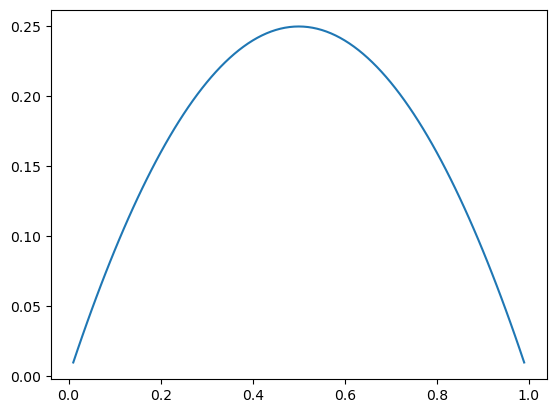

In [19]:
probs = np.arange(0.01, 1.0, 0.01) #вероятности от 0.01 до 0.99
variances = probs * (1 - probs) #дисперсии для этих вероятностей
sns.lineplot(x=probs, y=variances)

Дисперсия максимальна при $p = 0.5$ и нулевая при $p = 0.0$ и $p = 1.0$. Иначе говоря, если наша конверсия очень маленькая или очень большая, то вам может быть проще обнаружить различие, чем при 50%-ой конверсии - потому что шума и непредсказуемости во втором случае больше! Это объясняет огромную мощность при 5%-10% - и очень низкую при 50%-55%, несмотря на одинаковое абсолютное различие в конверсиях.

Соответственно, если варьировать не только значение контрольной конверсии, но и величину различия, вы будете получать очень разные результаты из-за того, как меняется дисперсия в обеих группах. 

## 3. Различия в предсказаниях моделей

Теперь разберёмся, почему при маленькой конверсии (и очень большой, хоть я это и не показывал) t-тест начинает вести себя отвратительно, зато при близости к 50%-ой конверсии он снова оказывается оптимальным тестом с точки зрения практики. Для этого я нагло утырю картинку из [этого блога](https://www.alexpghayes.com/post/2019-08-31_consistency-and-the-linear-probability-model/), где наглядно показано, какие предсказания генерируют линейная и логистическая регрессия для бинарной переменной:

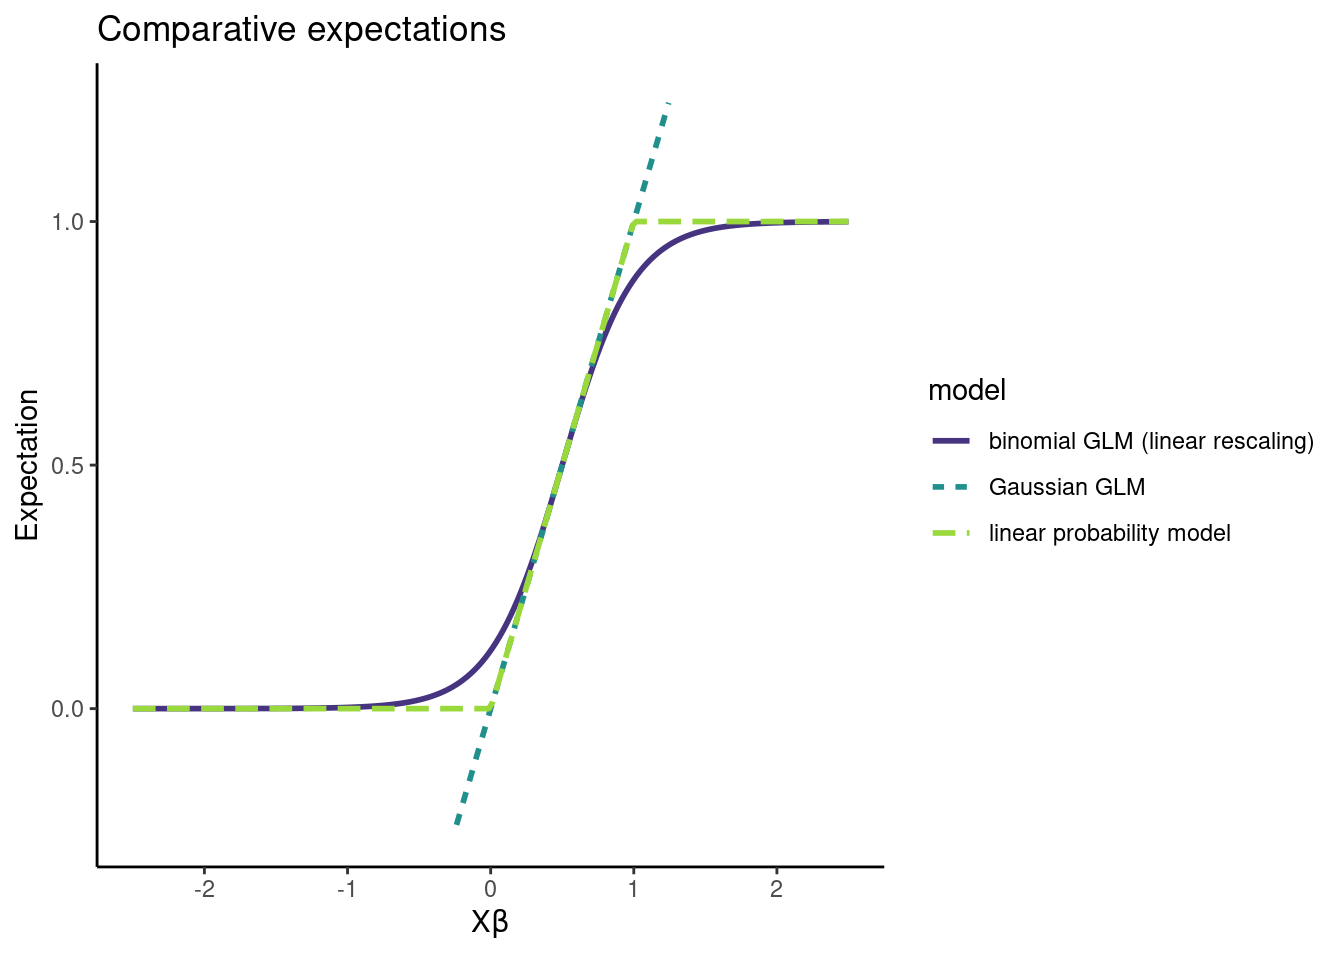

Что здесь что?

- **Gaussian GLM** - предсказания обычной линейной регрессии (напоминаю, что t-тест - разновидность линейной регрессии). Обратите внимание, что её предсказания все лежат на прямой линии и выходят за пределы 0 и 1 - это связано с допущением линейной регрессии, что изучаемая нами переменная лежит в диапазоне от $-\infty$ до $+\infty$, что не особо соответствует распределению Бернулли
- **linear probability model** - та же линейная регрессия, но предсказания искусственно зажаты между 0 и 1. Для наших целей - никакой разницы с прошлым вариантом.
- **binomial GLM** - это как раз логистическая регрессия (или подобная ей модель). Обратите внимание, что ближе к концам линия изгибается - эта модель уже знает, что переменная не может выходить за пределы 0 и 1 и уважает эти границы.

Соответственно, эта картинка объясняет подобное поведение двух методов:

1. При очень низких и очень высоких значениях конверсии логистическая модель более удачно отражает поведение нашей переменной, и при выраженной диспропорции выборок это ей играет на руку
2. Ближе к середине предсказания логистической и линейной моделей совпадают, и более адаптированная для таких взаимосвязей линейная модель (=t-тест) справляется гораздо лучше

А что с хи-квадратом? А он является непараметрическим методом. Непараметрические методы справляются лучше параметрических, когда их допущения не выполнены - и хуже, когда их допущения выполнены. Отсюда и такое поведение этого метода при диспропорции выборок, когда t-тест ломается, а логистическая регрессия - нет.

# Итоги

Повторюсь: если вы считаете размер выборки для конверсии (да и не только её), очень важно делать расчёты для вашей конкретной ситуации! Для каждой пары значений конверсии в тесте и контроле значения мощности/FPR будут свои - и ответственность за выбор этих значений лежит на вас как на аналитике.